<a href="https://colab.research.google.com/github/Shahnewaz-saadi/Rice_Leaf_disease_with_resnet50/blob/main/Rice_leaves_with_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

# Increase the timeout period to 300 seconds (5 minutes)
drive.mount('/content/drive', timeout_ms=300000)

Mounted at /content/drive


In [ ]:
import os
import shutil
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
# Add these import statements at the beginning of your code
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array

# Directory

In [ ]:
# def sample_images(source_dir, dest_dir, samples_per_class):
#     os.makedirs(dest_dir, exist_ok=True)

#     for class_name in os.listdir(source_dir):
#         class_path = os.path.join(source_dir, class_name)
#         if os.path.isdir(class_path):
#             # List all images in the class directory
#             images = os.listdir(class_path)

#             # Randomly select the specified number of images
#             sampled_images = random.sample(images, min(samples_per_class, len(images)))

#             # Copy sampled images to the destination directory
#             dest_class_dir = os.path.join(dest_dir, class_name)
#             os.makedirs(dest_class_dir, exist_ok=True)
#             for image_name in sampled_images:
#                 src_path = os.path.join(class_path, image_name)
#                 dest_path = os.path.join(dest_class_dir, image_name)
#                 shutil.copy(src_path, dest_path)

# # Define source and destination directories
# source_dir = '/content/drive/MyDrive/Rice Leaf Disease Images'
# train_dir = '/content/drive/MyDrive/Rice Leaf Disease/train'
# valid_dir = '/content/drive/MyDrive/Rice Leaf Disease/valid'
# test_dir = '/content/drive/MyDrive/Rice Leaf Disease/test'

# # Sample images for each split
# sample_images(source_dir, train_dir, 500)  # 500 images per class for training
# sample_images(source_dir, valid_dir, 100)  # 100 images per class for validation
# sample_images(source_dir, test_dir, 50)    # 50 images per class for testing

# print("Sampling complete!")

In [ ]:
# Define source and destination directories
source_dir = '/content/drive/MyDrive/Thesis Paper /Rice Leaf Disease'
train_dir = '/content/drive/MyDrive/Thesis Paper /Rice Leaf Disease/train'
valid_dir = '/content/drive/MyDrive/Thesis Paper /Rice Leaf Disease/valid'
test_dir = '/content/drive/MyDrive/Thesis Paper /Rice Leaf Disease/test'

# Visualization function

In [ ]:
def visualize_images_from_dir_grid(directory, num_images=20, images_per_row=4):
    """
    Visualizes images from a directory in a grid format.

    Parameters:
    - directory: Path to the dataset directory.
    - num_images: Total number of images to display.
    - images_per_row: Number of images to display per row.
    """
    classes = os.listdir(directory)
    classes = [cls for cls in classes if os.path.isdir(os.path.join(directory, cls))]

    print(f"Classes: {classes}")

    # Calculate the number of rows
    num_rows = num_images // images_per_row + int(num_images % images_per_row != 0)

    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(images_per_row * 3, num_rows * 3))
    axes = axes.flatten()  # Flatten the axes for easy iteration

    for i in range(num_images):
        # Randomly select a class
        selected_class = random.choice(classes)
        class_dir = os.path.join(directory, selected_class)

        # Randomly select an image from the class
        image_name = random.choice(os.listdir(class_dir))
        image_path = os.path.join(class_dir, image_name)

        # Load and display the image
        img = load_img(image_path, target_size=(224, 224))  # Resize for consistency
        img_array = img_to_array(img) / 255.0  # Normalize for better visualization

        axes[i].imshow(img_array)
        axes[i].set_title(selected_class)
        axes[i].axis('off')

    # Turn off any unused axes
    for j in range(num_images, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()



# Training image

Classes: ['Blast', 'Brownspot', 'Bacterialblight', 'Tungro', 'Healthy']


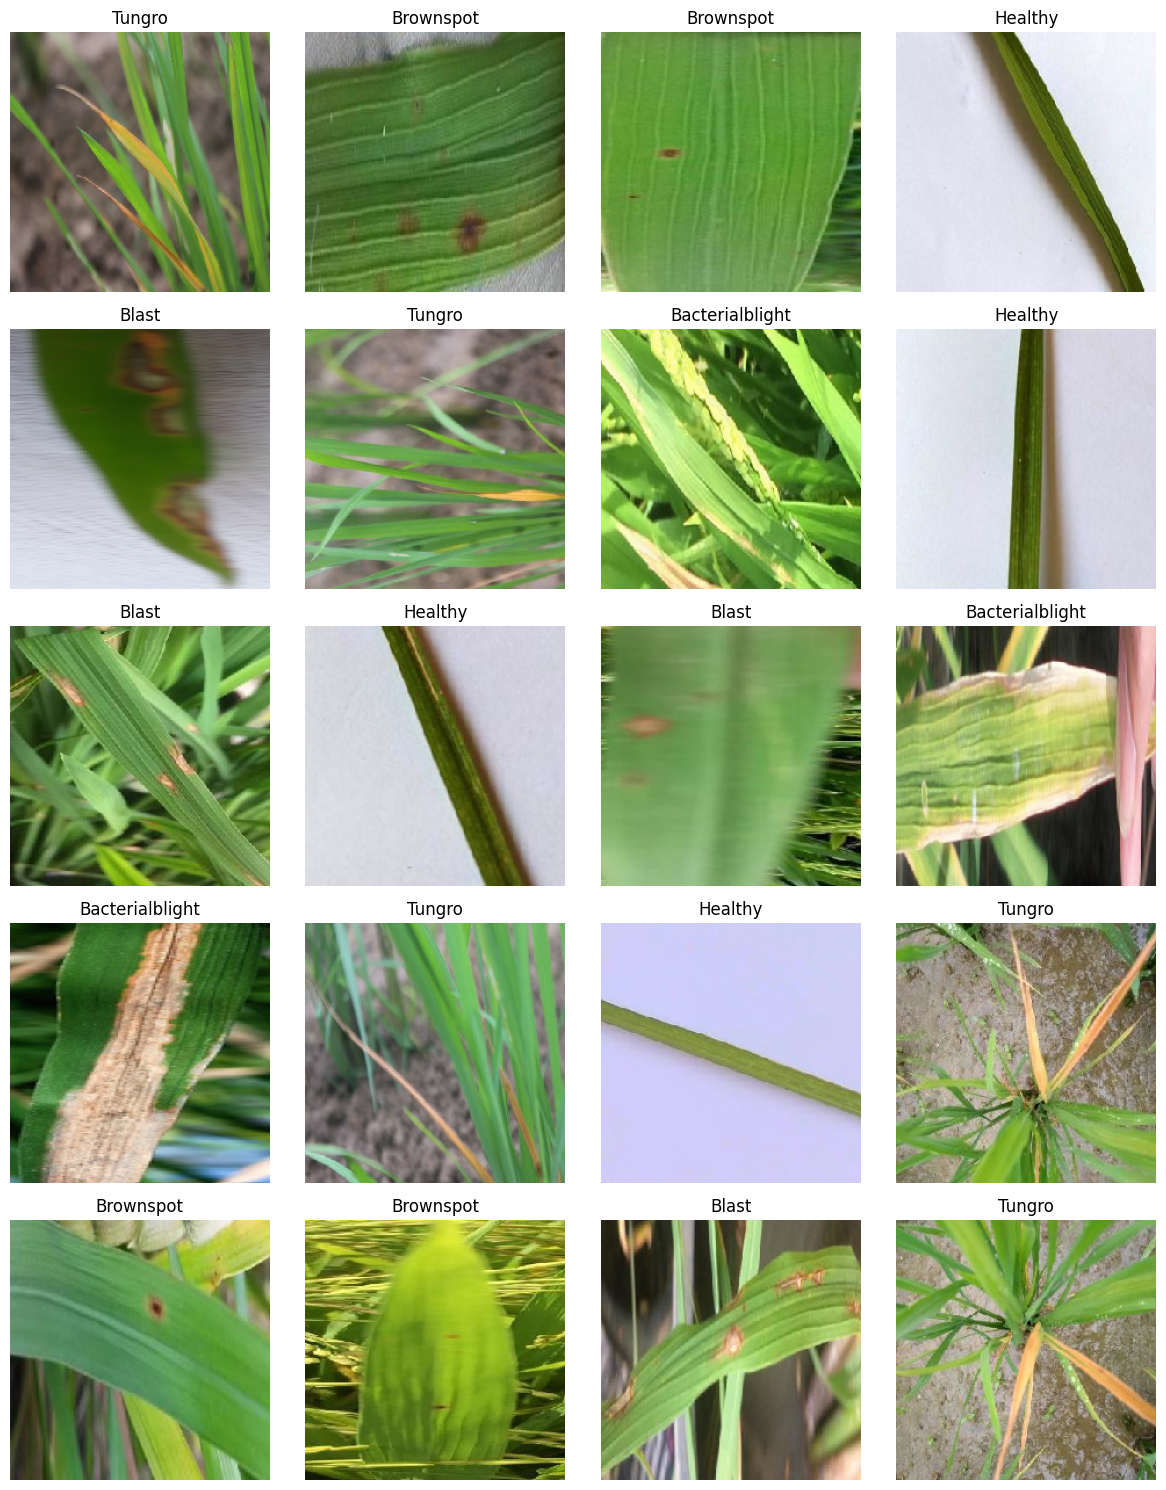

In [ ]:
visualize_images_from_dir_grid(train_dir, num_images=20, images_per_row=4)

# Validation Images

Classes: ['Blast', 'Brownspot', 'Bacterialblight', 'Tungro', 'Healthy']


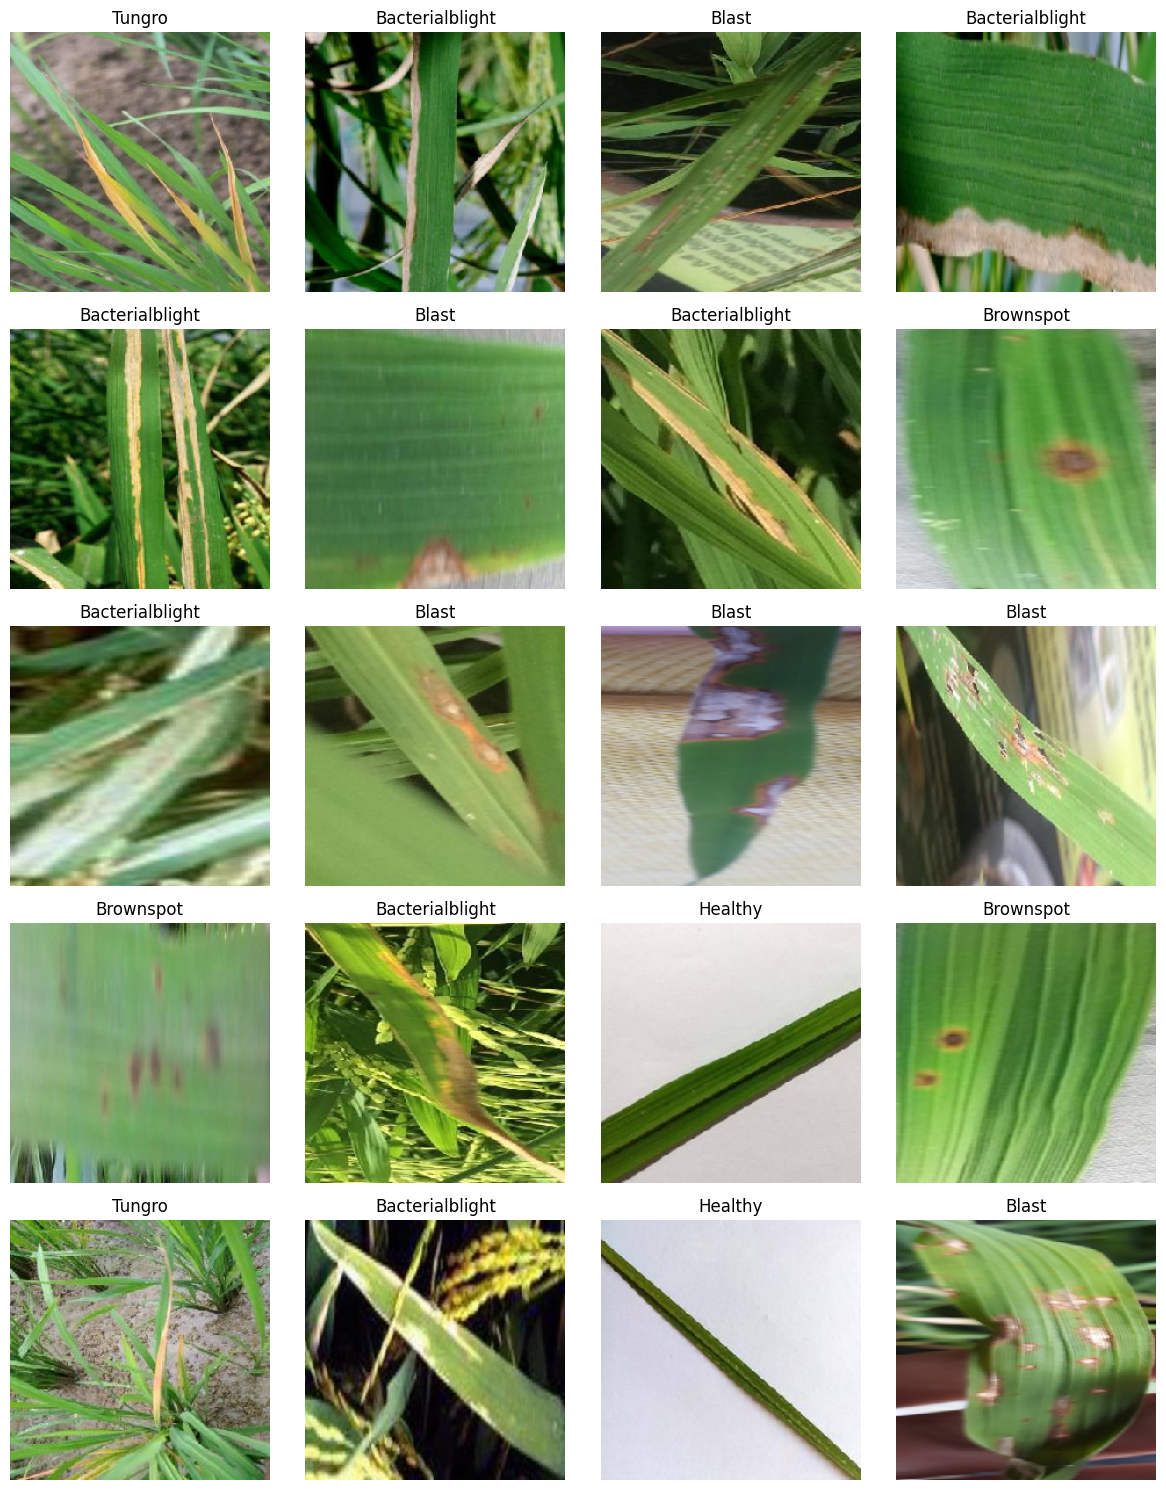

In [ ]:
visualize_images_from_dir_grid(valid_dir, num_images=20, images_per_row=4)

# Test Images

Classes: ['Blast', 'Brownspot', 'Bacterialblight', 'Tungro', 'Healthy']


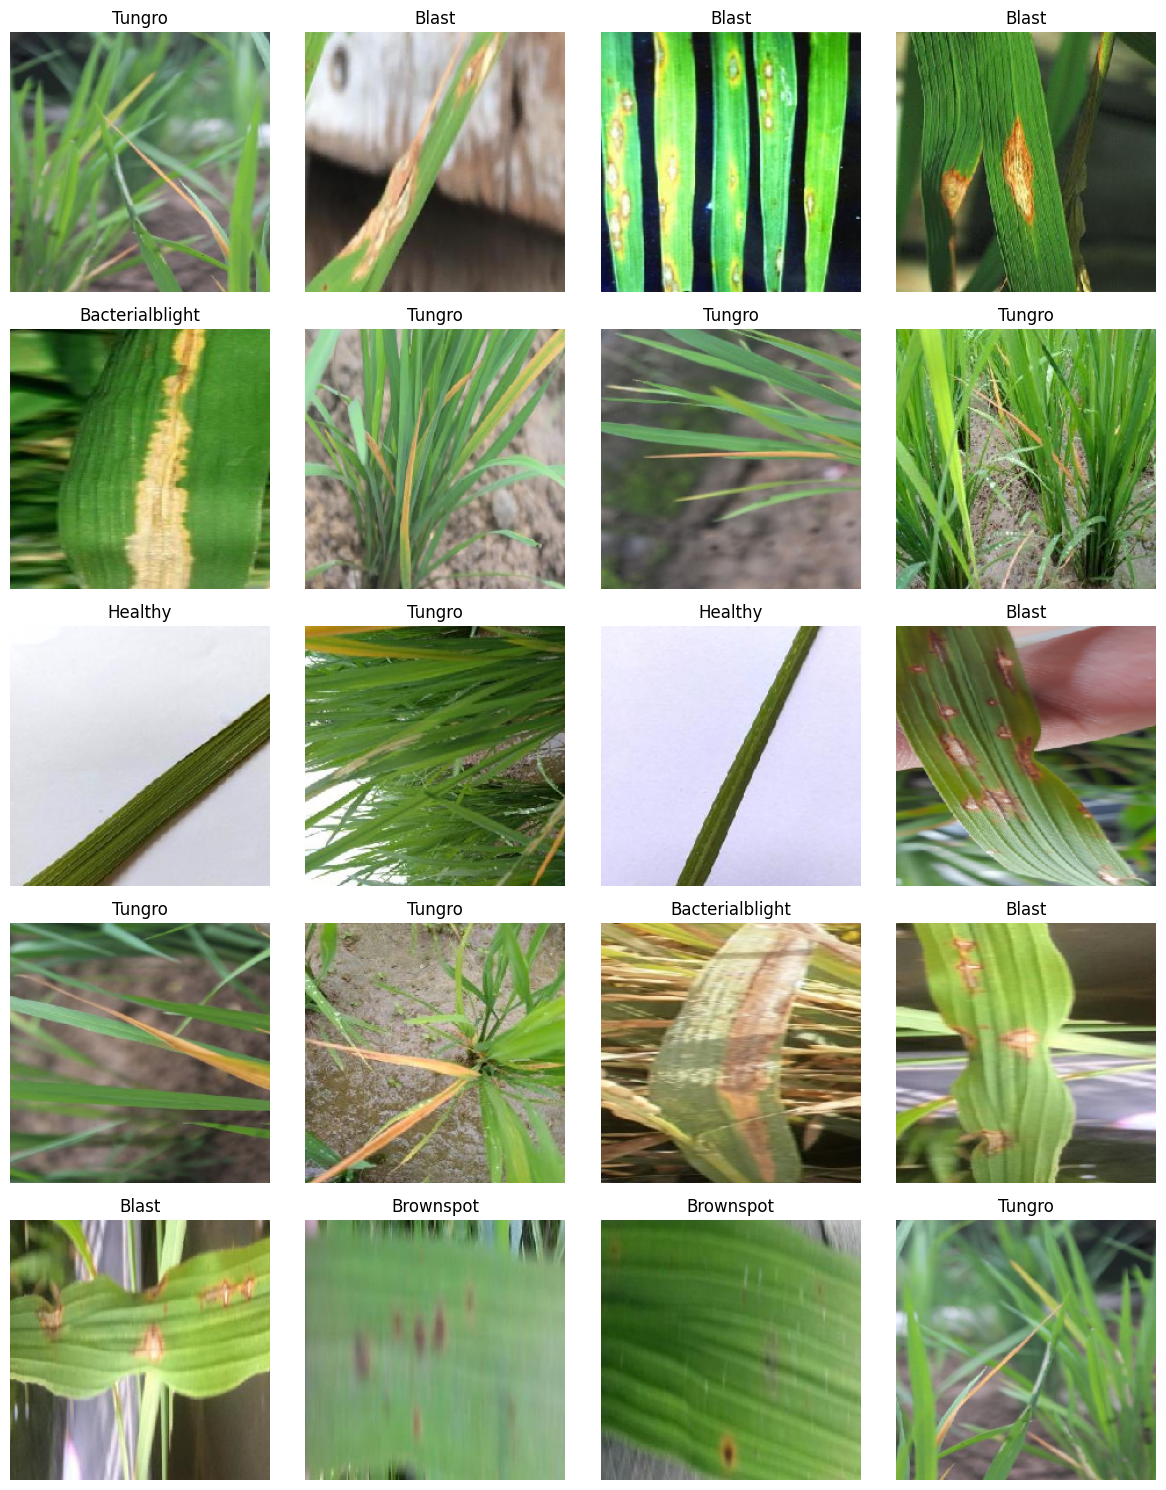

In [ ]:
visualize_images_from_dir_grid(test_dir, num_images=20, images_per_row=4)

In [ ]:
# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input
)

# Validation and test data generator
test_valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Create generators for training, validation, and testing
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

valid_generator = test_valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_valid_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  # No labels for test images
    shuffle=False
)

Found 2500 images belonging to 5 classes.
Found 500 images belonging to 5 classes.
Found 250 images belonging to 5 classes.


In [ ]:
# Define checkpoint directory
checkpoint_dir = '/content/drive/MyDrive/Thesis Paper /Rice_Leaves_Disease_Model_Checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Find the latest checkpoint
checkpoint_files = sorted([f for f in os.listdir(checkpoint_dir) if f.endswith('.keras')])

if checkpoint_files:
    # Load the most recent checkpoint
    latest_checkpoint = os.path.join(checkpoint_dir, checkpoint_files[-1])
    print(f"Resuming training from checkpoint: {latest_checkpoint}")
    model = load_model(latest_checkpoint)
else:
    print("No checkpoint found. Starting training from scratch.")

Resuming training from checkpoint: /content/drive/MyDrive/Thesis Paper /Rice_Leaves_Disease_Model_Checkpoints/model_epoch_05_val_acc_1.00.keras


In [ ]:
# Load ResNet50 base model without the top (fully connected) layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model layers

# # modify start for fine tunig
# base_model.trainable = True

# Fine-tune from this layer onwards
# fine_tune_at = 100

# # Freeze all the layers before the `fine_tune_at` layer
# for layer in base_model.layers[:fine_tune_at]:
#     layer.trainable = False
# #modify end


# Add custom layers on top of ResNet50
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dense(train_generator.num_classes, activation='softmax')  # Number of classes
])

#Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Lower learning rate
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

model.summary()
print(train_generator.num_classes)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           5,125 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,691,013 (98.00 MB)

 Trainable params: 2,103,301 (8.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

5


In [ ]:
print(len(base_model.layers))

175


In [ ]:
checkpoint_filepath = os.path.join(checkpoint_dir, 'model_epoch_{epoch:02d}_val_acc_{val_accuracy:.2f}.keras')

checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    verbose=1
)

In [ ]:
# history = model.fit(
#     train_generator,
#     validation_data=valid_generator,
#     epochs=10,  # Number of additional epochs
#     callbacks=[checkpoint_callback, early_stopping_callback]
# )

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
saved_model_path = '/content/drive/MyDrive/Thesis Paper /Rice_Leaves_Disease_Model_Checkpoints/model_epoch_01_val_acc_0.97.keras'
model = load_model(saved_model_path)
print("Model loaded successfully!")
model.summary()

Model loaded successfully!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           5,125 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,897,617 (114.05 MB)

 Trainable params: 2,103,301 (8.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 4,206,604 (16.05 MB)

In [ ]:
# import matplotlib.pyplot as plt

# # Extract accuracy data
# train_accuracy = history.history['accuracy']
# val_accuracy = history.history['val_accuracy']
# epochs = range(1, len(train_accuracy) + 1)

# # Plot accuracy
# plt.figure(figsize=(8, 6))
# plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
# plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.grid(True)
# plt.show()

In [ ]:
# import matplotlib.pyplot as plt

# # Extract loss data
# train_loss = history.history['loss']
# val_loss = history.history['val_loss']
# epochs = range(1, len(train_loss) + 1)

# # Plot training and validation loss
# plt.figure(figsize=(8, 6))
# plt.plot(epochs, train_loss, 'b-', label='Training Loss')
# plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.grid(True)
# plt.show()


In [ ]:
# import matplotlib.pyplot as plt

# # Extract loss data
# train_loss = history.history['loss']
# val_loss = history.history['val_loss']
# epochs = range(1, len(train_loss) + 1)

# # Find the best epoch based on validation loss
# best_epoch = val_loss.index(min(val_loss)) + 1  # Adding 1 since epochs start from 1
# best_val_loss = min(val_loss)

# # Plot training and validation loss
# plt.figure(figsize=(8, 6))
# plt.plot(epochs, train_loss, 'b-', label='Training Loss')
# plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
# plt.scatter(best_epoch, best_val_loss, color='green', label=f'Best Epoch: {best_epoch}')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.grid(True)

# # Annotate the best epoch
# plt.annotate(f'Best Val Loss: {best_val_loss:.4f}',
#              xy=(best_epoch, best_val_loss),
#              xytext=(best_epoch, best_val_loss + 0.05),
#              arrowprops=dict(facecolor='black', arrowstyle='->'),
#              fontsize=10)

# # Show plot
# plt.show()


In [ ]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.applications.resnet50 import preprocess_input

# # Path to test dataset
# test_dir = '/content/drive/MyDrive/Rice Leaf Disease/test'

# # Test data generator
# # test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# # test_generator = test_datagen.flow_from_directory(
# #     test_dir,
# #     target_size=(224, 224),
# #     batch_size=32,
# #     class_mode='categorical',
# #     shuffle=True  # Keep the order consistent for evaluation
# # )
# test_generator = test_valid_datagen.flow_from_directory(
#     test_dir,
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='categorical',  # No labels for test images
#     shuffle=False
# )

In [ ]:
# Evaluate the model on the test set
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

# Print the test accuracy
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# print(f"Test Accuracy: {test_accuracy:.2f}")
# print(f"Test Loss: {test_loss:.2f}")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 75s 9s/step - accuracy: 0.9772 - loss: 0.0952
Test Accuracy: 98.00%


In [ ]:
print(test_generator.class_indices)


{'Bacterialblight': 0, 'Blast': 1, 'Brownspot': 2, 'Healthy': 3, 'Tungro': 4}


In [ ]:
# import numpy as np

# # Get true labels and predicted probabilities
# y_true = []
# y_pred = []

# for images, labels in test_generator:
#     y_true.extend(np.argmax(labels.numpy(), axis=1))  # Convert one-hot labels to class indices
#     predictions = model.predict(images)
#     y_pred.extend(np.argmax(predictions, axis=1))  # Get predicted class indices

# y_true = np.array(y_true)
# y_pred = np.array(y_pred)

8/8 ━━━━━━━━━━━━━━━━━━━━ 57s 7s/step
Class: Bacterialblight
  TP: 48
  TN: 198
  FP: 2
  FN: 2

Class: Blast
  TP: 49
  TN: 197
  FP: 3
  FN: 1

Class: Brownspot
  TP: 48
  TN: 200
  FP: 0
  FN: 2

Class: Healthy
  TP: 50
  TN: 200
  FP: 0
  FN: 0

Class: Tungro
  TP: 50
  TN: 200
  FP: 0
  FN: 0



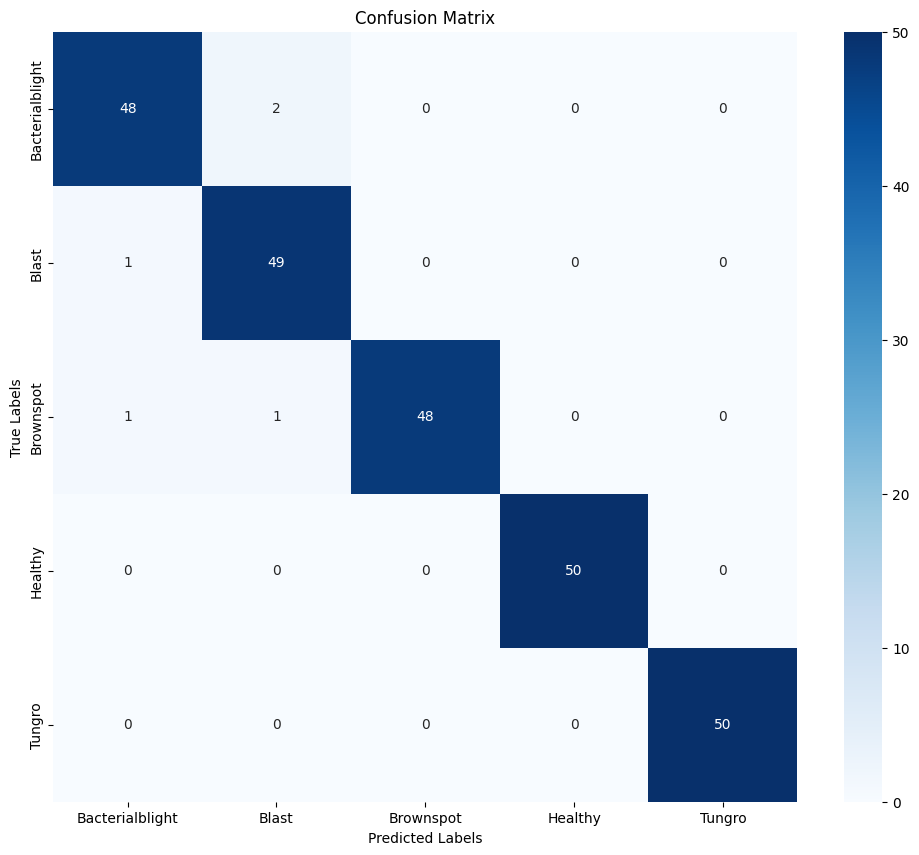

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Step 1: Extract True Labels
true_labels = test_generator.classes  # Extract true labels from the generator
class_indices = test_generator.class_indices  # Class-to-index mapping
classes = list(class_indices.keys())  # Class names

# Step 2: Generate Predictions
# Generate predictions for the test set
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
predicted_labels = np.argmax(predictions, axis=1)  # Convert probabilities to class indices

# Step 3: Compute Confusion Matrix
# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Calculate TP, TN, FP, FN
TP = np.diag(conf_matrix)
FP = np.sum(conf_matrix, axis=0) - TP
FN = np.sum(conf_matrix, axis=1) - TP
TN = np.sum(conf_matrix) - (TP + FP + FN)

# Print TP, TN, FP, FN for each class
for i, class_name in enumerate(classes):
    print(f"Class: {class_name}")
    print(f"  TP: {TP[i]}")
    print(f"  TN: {TN[i]}")
    print(f"  FP: {FP[i]}")
    print(f"  FN: {FN[i]}")
    print()

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes, fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# from sklearn.metrics import confusion_matrix
# import numpy as np

# # Compute confusion matrix
# cm = confusion_matrix(y_true, y_pred)

# # Initialize TP, TN, FP, FN
# TP = np.diag(cm)  # True Positives are the diagonal elements
# FP = np.sum(cm, axis=0) - TP  # False Positives are column sums minus diagonal
# FN = np.sum(cm, axis=1) - TP  # False Negatives are row sums minus diagonal
# TN = np.sum(cm) - (TP + FP + FN)  # True Negatives are the total sum minus TP, FP, FN

# # Initialize precision, recall, and F1-score
# precision = TP / (TP + FP + 1e-10)  # Add a small value to avoid division by zero
# recall = TP / (TP + FN + 1e-10)
# f1_score = 2 * (precision * recall) / (precision + recall + 1e-10)

# # Display results for each class
# for i, class_name in enumerate(classes):
#     print(f"Class: {class_name}")
#     print(f"  TP: {TP[i]}")
#     print(f"  TN: {TN[i]}")
#     print(f"  FP: {FP[i]}")
#     print(f"  FN: {FN[i]}")
#     print()

# # Display results for each class
# for i, class_name in enumerate(class_names):
#     print(f"Class: {class_name}")
#     print(f"  Precision: {precision[i]:.4f}")
#     print(f"  Recall: {recall[i]:.4f}")
#     print(f"  F1-Score: {f1_score[i]:.4f}")
#     print()


In [ ]:
# import matplotlib.pyplot as plt

# # Extract accuracy data
# train_accuracy = history.history['accuracy']
# val_accuracy = history.history['val_accuracy']
# epochs = range(1, len(train_accuracy) + 1)

# # Test accuracy
# test_accuracy = 0.9267  # Replace with your actual test accuracy

# # Plot training and validation accuracy
# plt.figure(figsize=(8, 6))
# plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
# plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
# plt.axhline(y=test_accuracy, color='g', linestyle='--', label=f'Test Accuracy: {test_accuracy*100:.1f}%')
# plt.title('Training, Validation, and Testing Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.grid(True)
# plt.show()


 Confusion Matrix

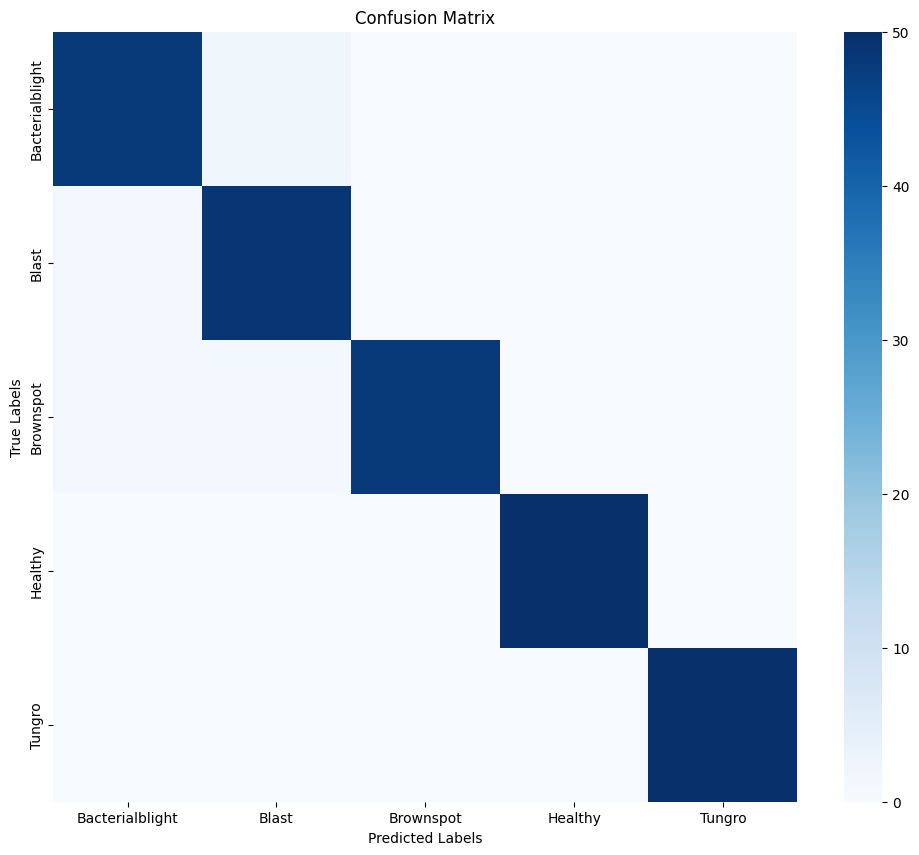

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Step 1: Extract True Labels
true_labels = test_generator.classes  # Extract true labels from the generator
class_indices = test_generator.class_indices  # Class-to-index mapping
classes = list(class_indices.keys())  # Class names

# Step 2: Generate Predictions
# Generate predictions for the test set
# predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
# predicted_labels = np.argmax(predictions, axis=1)  # Convert probabilities to class indices
# Step 3: Compute Confusion Matrix
# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=False, cmap='Blues', xticklabels=classes, yticklabels=classes, fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


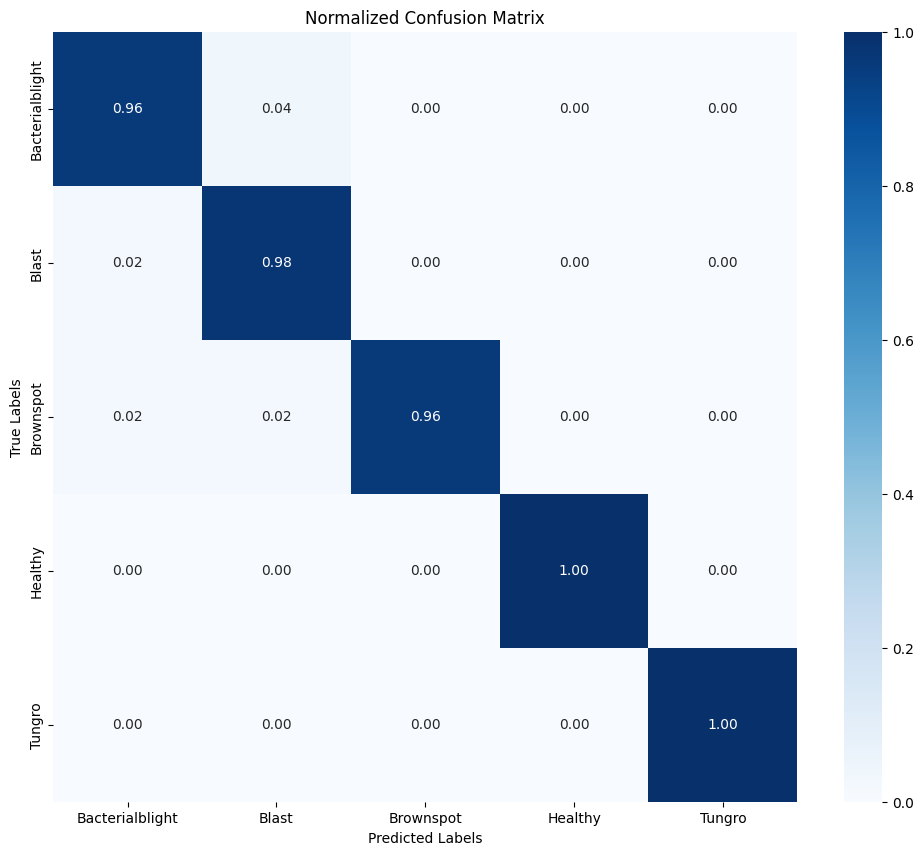

                 precision    recall  f1-score   support

Bacterialblight       0.96      0.96      0.96        50
          Blast       0.94      0.98      0.96        50
      Brownspot       1.00      0.96      0.98        50
        Healthy       1.00      1.00      1.00        50
         Tungro       1.00      1.00      1.00        50

       accuracy                           0.98       250
      macro avg       0.98      0.98      0.98       250
   weighted avg       0.98      0.98      0.98       250



In [ ]:

# Step 4: Display Normalized Confusion Matrix (Optional)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix_normalized, annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes, fmt='.2f')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()

# Step 5: Print Classification Report (Optional)
report = classification_report(true_labels, predicted_labels, target_names=classes)
print(report)